In [1]:
!pip install transformers

In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Input data
file_path = '/kaggle/input/preprocessed-data/data_preprocessed.csv'
data = pd.read_csv(file_path)
print(data.head(20))

     ProductId  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0   B001E4KFG0                     1                       1      5   
1   B00813GRG4                     0                       0      1   
2   B000LQOCH0                     1                       1      4   
3   B000UA0QIQ                     3                       3      2   
4   B006K2ZZ7K                     0                       0      4   
5   B006K2ZZ7K                     0                       0      5   
6   B006K2ZZ7K                     0                       0      5   
7   B000E7L2R4                     1                       1      5   
8   B00171APVA                     0                       0      5   
9   B0001PB9FE                     1                       1      5   
10  B0009XLVG0                     4                       4      5   
11  B0009XLVG0                     1                       1      1   
12  B001GVISJM                     2                       2      4   
13  B0

In [26]:
text_all = data.Text.copy() #just use the main text in this example
text_all

0         I have bought several of the Vitality canned d...
1         Product arrived labeled as Jumbo Salted Peanut...
2         This is a confection that has been around a fe...
3         If you are looking for the secret ingredient i...
4         I got a wild hair for taffy and ordered this f...
                                ...                        
538158    Great for sesame chicken..this is a good if no...
538159    I'm disappointed with the flavor. The chocolat...
538160    These stars are small, so you can give 10-15 o...
538161    These are the BEST treats for training and rew...
538162    I am very satisfied ,product is as advertised,...
Name: Text, Length: 538163, dtype: object

In [28]:
# Generate a random sample of 700 cases
texts = text_all.sample(n=700, random_state=1)
texts

324919    This stuff is great. The cats love it ( all fl...
391045    This is my second experience with microwaved w...
320084    All of my cats adore these treats. One cat in ...
267651    Amish Kitchens Extra-Thick Kluski Egg Noodles ...
16396     Great price for 240 pieces in total. It's swee...
                                ...                        
345251    We use these popcorn packs for our party renta...
520025    Eat at your own risk.  Once I would open a bag...
386907    My daughter, who is NO cook, can make a mean l...
388122    Some reviews complain this product has no heat...
239983    The sauce is green, and that's about as "jalep...
Name: Text, Length: 700, dtype: object

We need to get an idea of how long our training documents are.
I'm not going to use the same tokenizer as the GPT2 one, which is a byte pair encoding tokenizer. Instead, I'm using a simple one just to get a rough understanding.

/tmp/ipykernel_34/2653391606.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

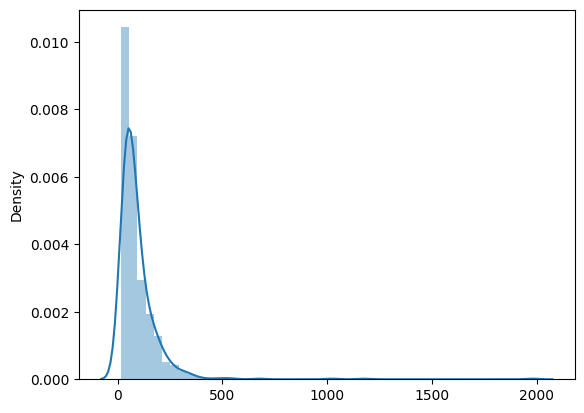

In [29]:
doc_lengths = []

for text in texts:

    # get rough token count distribution
    tokens = nltk.word_tokenize(text)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [30]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.004285714285714286

In [31]:
np.average(doc_lengths)

94.83714285714285

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [32]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

In [33]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders

GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. 

This can be mitigated by accumulating the gradients but that is out of scope here.

In [34]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a dataset class.

I'm passing in the tokenizer as an argument but normally I would instantiate it within the class.

In [35]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading the docs. I've wrapped each text in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the text is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the text is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [36]:
dataset = GPT2Dataset(texts, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  630 training samples
   70 validation samples


In [37]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [39]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [40]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [41]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [43]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [44]:
## ChatGPT Code
import time
import torch
from transformers import AutoTokenizer

# Assume 'model', 'optimizer', 'scheduler', 'device', 'train_dataloader', 'validation_dataloader', and 'epochs' are predefined.

total_t0 = time.time()
training_stats = []

# Load tokenizer with the correct pad_token
#tokenizer = AutoTokenizer.from_pretrained('your-model-name')
pad_token_id = tokenizer.pad_token_id  # Ensure pad_token_id is correctly defined

model = model.to(device)

for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_labels, b_masks = batch[0].to(device), batch[0].to(device), batch[1].to(device)

        # Ensure attention masks are correctly passed
        model.zero_grad()
        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks)
        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,} of {:>5,}. Loss: {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=random.randint(1, 30000),
                do_sample=True,
                top_k=50,
                max_length=200,
                top_p=0.95,
                num_return_sequences=1,
                pad_token_id=pad_token_id  # Explicit pad_token_id for generation
            )

            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids, b_labels, b_masks = batch[0].to(device), batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks)
            loss = outputs[0]
            batch_loss = loss.item()
            total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))



======== Epoch 1 / 5 ========
Training...
  Batch   100 of   315. Loss: 0.4451545774936676. Elapsed: 0:00:51.
0:  bipartisan" amount of money to be made with the cost of the "The use of the Department of the Department of the Department of the U.S. Department of the Department of the Department of the "The cost of the Department of the Department of the Department of the US.

 "Department of the
 Department of the Department of
  Batch   200 of   315. Loss: 1.3308225870132446. Elapsed: 0:01:43.
0:  increasingSardines are the strongest and most delicious in the most variety of vegetables.  (Sardines are very fine, like carrots that turn into vegetables with a hint of salt.  I can't think of a better substitute for sweetened tea leaves.  You can use these to make it easier to read and digest the flavor of foods served.<br /><br /><br />
  Batch   300 of   315. Loss: 0.41481465101242065. Elapsed: 0:02:34.
0: dayHuffington Post-Gazeta! The company's new products have a different price poi

In [46]:
## Example Notebook Code
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()
         
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    315. Loss: 0.13798679411411285.   Elapsed: 0:00:50.
0:  glimpseWe lived near a gas station with some friends and asked if it was OK to buy a K-cups at the pump. We tried several of the K-cups. The one we liked best was the "green" version. I drank it like water. I really do not see why it should be called a flavored beverage, it just tastes like drinking flavored water.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    315. Loss: 0.1446772664785385.   Elapsed: 0:01:41.
0:  LaureThis is what I like about the Gourmet Macchiato.  The spices are very light and have a very "soft" taste to them.  I love that they are made in the USA!  I would recommend them to anyone!!!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    315. Loss: 0.11537440866231918.   Elapsed: 0:02:31.
0: ismIf you're on a tight budget, we recommend trying out this protein shake. It's rich, complex, and quick to microwave. I haven't tried it all, but I have to give it a try anyways. If you're worried about sodium and potassium intake, we recommend trying out "Affordable protein shake" which is a whole grain, low fat, high protein shake. The protein shake is ultra low in salt and mostly non-existent in any type of sweeteners.<br /><br />This isn't cheap, either. Try "Affordable protein shake" at your local grocery store. If you like the flavor of the protein shake, "Maple protein shake" at the grocery store.<br /><br />This is great, but I'd say "better" if you were looking for something other than the standard "Affordable" protein shake.<br /><br />Taste is important, too. If you like Maple protein, "Maple Vanilla"

  Average training loss: 0.24
  Training epoch took: 0:02:41

Running Validation...
  Validation 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    315. Loss: 0.2758260667324066.   Elapsed: 0:00:50.
0: ounI was very happy when I found this product on Amazon as the price is only a dollar cheaper than what I paid for it locally. The ingredients list didn't mention any chemicals, so I had to go to the store to get one.  It has a great mustard flavor, which I like and use in my salads as well. It's not as strong as some of the other flavors I've tried.  It is great mustard that doesn't have as many calories and a lot of flavor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    315. Loss: 0.09655933082103729.   Elapsed: 0:01:41.
0:  electionThe food came with all three flavors, the jalapeno served with green beans and the mint on top. There was no hint of salt, it was just green tea flavor, along with some mint leaves in the middle. There is also the hint of chalky, which has a very strong peppery taste. It does not seem to impact the taste of the tea itself, it just tastes better with Green Tea.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    315. Loss: 0.12222589552402496.   Elapsed: 0:02:31.
0:  crazyI love chicken flavored chai.  There is such a great flavor.  And chicken nuggets, fried etc.  It is a great meal replacement.

  Average training loss: 0.24
  Training epoch took: 0:02:39

Running Validation...
  Validation Loss: 0.49
  Validation took: 0:00:05

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    315. Loss: 0.1450691968202591.   Elapsed: 0:00:50.
0:  benchI love dark chocolate.  It is very light and airy, which helps to keep my hair dry and cool.  It gives me a very nice chocolatey flavor without the calories or the other stuff.  I would definitely buy it again and again


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    315. Loss: 0.28753215074539185.   Elapsed: 0:01:40.
0:  incorporatedI love this snack. I make my own pumkin and chicken fried rice in it and it tastes great with my meals. I use it on yogurt as a topping and add more if I like my chicken nuggets. I also use it as a topping for chips, soups, etc.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    315. Loss: 0.599696695804596.   Elapsed: 0:02:31.
0: PeterThese were a good idea. I'd look for coupons in the store and if I needed more, I could get them elsewhere, which made them very convenient.<br /><br />Nice and easy to use. If I was a picky eater, these wouldn't be my first choice.<br /><br />Will definitely buy again!

  Average training loss: 0.24
  Training epoch took: 0:02:39

Running Validation...
  Validation Loss: 0.49
  Validation took: 0:00:05

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    315. Loss: 0.6151825785636902.   Elapsed: 0:00:50.
0: uringI bought these because I can see the calorie count on these from an all over-the-board calorie bar. I also have a Harvard weight loss that isnt maintained, so these are a great snack and I would not be disappointed. My only complaint is that they dont have as many calories as some of the other bars that have been available.<br /><br />I have also tried to limit my consumption of processed and fruit/vegetarian foods. I used to love organic and I am now eating more fruits and vegetables and dairy.<br /><br />The problem for me is that eating them all the time is no fun. I have tried a bunch of processed foods over the last few months, which have all but single-handedly put me off eating any processed foods since I am so used to all of them and have so many calories to burn.<br /><br />Also, I am now addicted to the Ridder bars I have tried. Ridder bars sell


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    315. Loss: 0.13200989365577698.   Elapsed: 0:01:42.
0:  reproductiveThis is my second experience with green tea.  I've been trying over 100 teas over the last few months, and I absolutely love every one.  It was wonderful that I could get a nice glass of green tea from the Keurig as soon as I got home and opened the box.  It is so delicious and so flavorful (I usually steep mine in a French press for 4 minutes) that I let loose a little in my mouth.  I just poured the rest in the Keurig to let the flavors float in and out.  Now I know why green tea lovers are so excited when I open the box--they are drinking green tea all the time.  I've had other teas with less bitter green teas (asparagas, miojas, etc) and this one tastes just like green tea!  This is the best green tea I've had!  It's a very light bodied green tea with lots of flavor. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    315. Loss: 0.18775798380374908.   Elapsed: 0:02:34.
0:  zoneI have been a fan of the Newman Newman brand of crack for many years.  We used to enjoy the Newman brand and would come home and find the Newman Newman brand was in every crack house we had ever tried.  At the time, I was struggling to find a good substitute for the Newman brand.  But, after a few attempts with the Newman brand, I was hooked!!!  This crack is so flavorful and full-bodied.  I can't wait to come back to get more from the Newman brand, and will definitely be ordering more!

  Average training loss: 0.25
  Training epoch took: 0:02:42

Running Validation...
  Validation Loss: 0.49
  Validation took: 0:00:05

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    315. Loss: 0.1381380707025528.   Elapsed: 0:00:50.
  Validation Loss: 0.49
  Validation took: 0:00:05

Training complete!
Total training took 0:13:46 (h:mm:ss)


Let's view the summary of the training process.

In [49]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.24,0.49,0:02:41,0:00:05
2,0.24,0.49,0:02:39,0:00:05
3,0.24,0.49,0:02:39,0:00:05
4,0.25,0.49,0:02:42,0:00:05
5,0.24,0.49,0:02:38,0:00:05


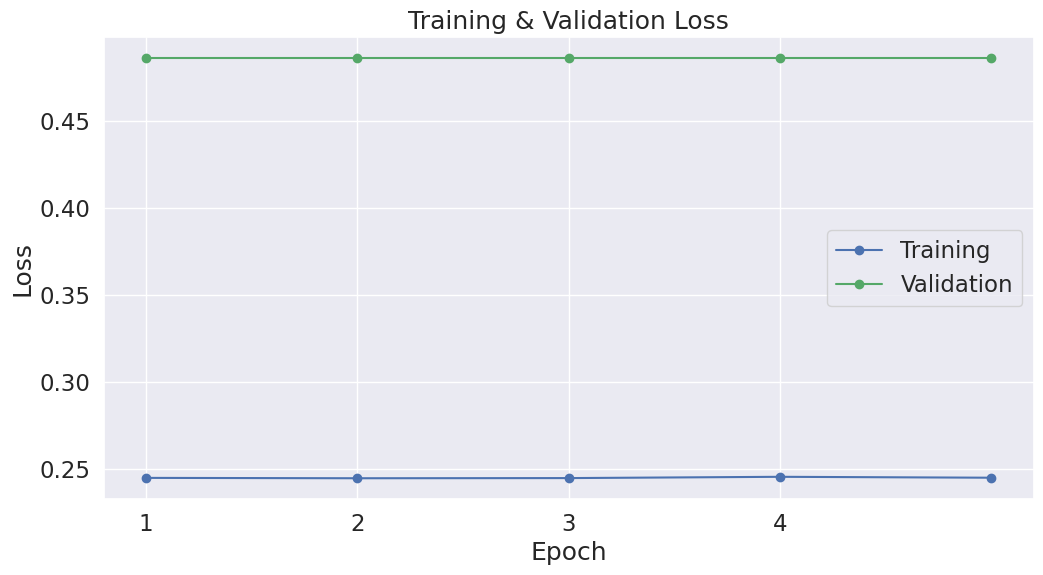

In [50]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [51]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model

In [52]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [53]:
!ls -l --block-size=K ./model_save/

total 487560K
-rw-r--r-- 1 root root      1K Jun 24 11:03 added_tokens.json
-rw-r--r-- 1 root root      1K Jun 24 11:03 config.json
-rw-r--r-- 1 root root      1K Jun 24 11:03 generation_config.json
-rw-r--r-- 1 root root    446K Jun 24 11:03 merges.txt
-rw-r--r-- 1 root root 486114K Jun 24 11:03 model.safetensors
-rw-r--r-- 1 root root      1K Jun 24 11:03 special_tokens_map.json
-rw-r--r-- 1 root root      1K Jun 24 11:03 tokenizer_config.json
-rw-r--r-- 1 root root    976K Jun 24 11:03 vocab.json


In [54]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

ls: cannot access './model_save/pytorch_model.bin': No such file or directory


In [55]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


# Generate Text

In [56]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: We tried this out several times and it was great!  This is not the best honey on the market for sure but I like that it is made with pure organic ingredients.  Thanks for making this!  Yum!


1: I tried this tea four times a week, and this was my favorite. The tea is deep red with a hint of green tea in the middle. I have thrown out the starter after trying several times a year and no matter how long it brews, I always have a nice thick cup in the fridge. I usually add sweetener if it tastes good to drink. It has a lovely red-tasting taste to it. I would recommend this to anyone.


2: A must have snack to keep a busy mother and her 3 year old baby happy! The bag is sturdy as well as easy to store and the pouch is easy to use. The pouch is very big and you can store your stuff inside! So glad you found this product!


